# https://www.kaggle.com/aleksandrmogilevskiy/pytorch-conv-layer-96-acc

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import os
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torch.nn as nn
import torch.nn.functional as F

# !pip install torchsummary
# from torchsummary import summary

%matplotlib inline

In [2]:
# Checking device: cuda or cpu
torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# device
# torch.cuda.get_device_name(0)

In [3]:
data_dir_train = '../input/fruits/fruits-360_dataset/fruits-360/Training'
data_dir_test = '../input/fruits/fruits-360_dataset/fruits-360/Test'

In [4]:
size_pictures = 100
data_transforms = transforms.Compose([transforms.Resize((size_pictures, size_pictures)),transforms.ToTensor()])

In [5]:
data_train = ImageFolder(root=data_dir_train,transform=data_transforms)
data_test = ImageFolder(root=data_dir_test,transform=data_transforms)
print("Train data length:{}\nTest data length:{}".format(len(data_train), len(data_test)))

Train data length:67692
Test data length:22688


In [6]:
LABELS = os.listdir(data_dir_train)
print("Label length:{}".format(len(LABELS)))

Label length:131


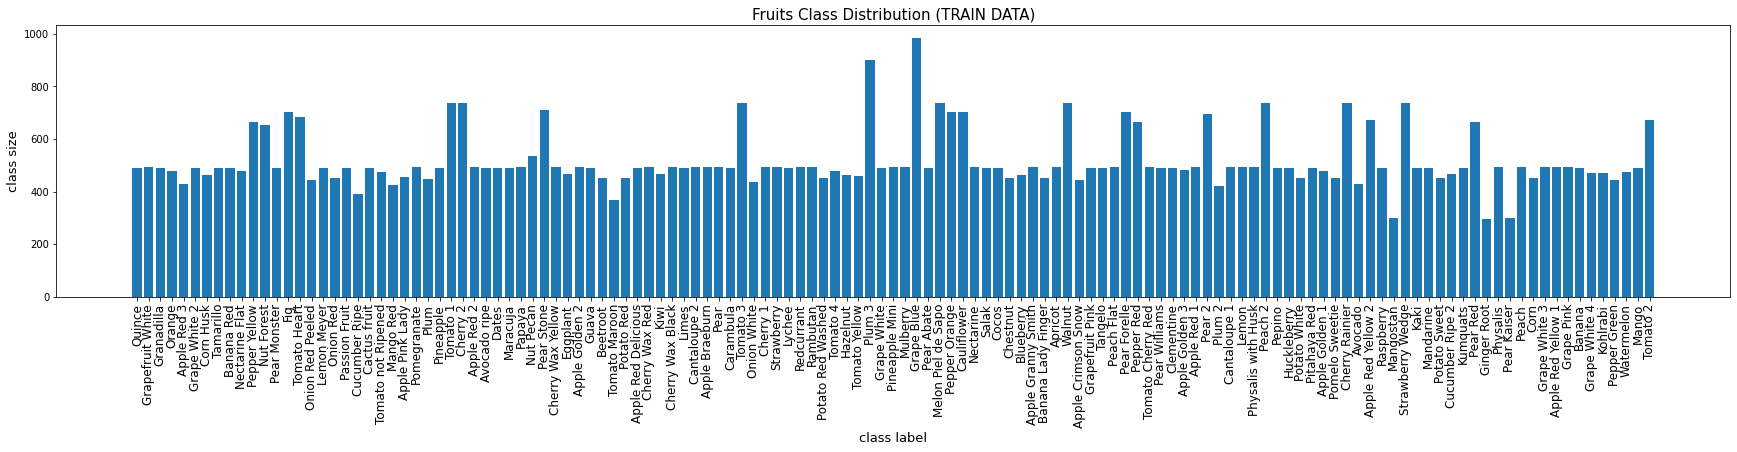

In [7]:
# plot class distributions of whole train data_train
counts = {}
for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(data_dir_train, l)))

    
plt.figure(figsize=(30, 5))
plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=90)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('Fruits Class Distribution (TRAIN DATA)', fontsize=15);

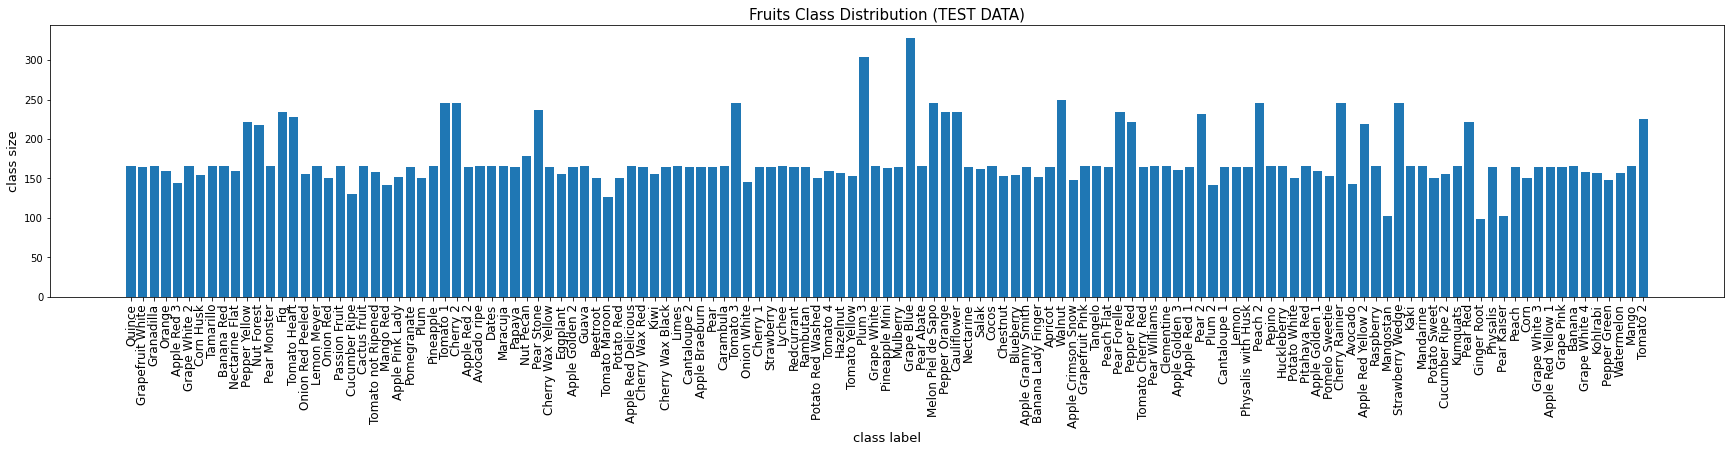

In [8]:
# plot class distributions of whole test data_test
counts = {}
for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(data_dir_test, l)))
    
plt.figure(figsize=(30, 5))
plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=90)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('Fruits Class Distribution (TEST DATA)', fontsize=15);

In [9]:
def show_random_image():
    index = np.random.randint(0,len(data_train))
    return data_train[index]
img, label = show_random_image()

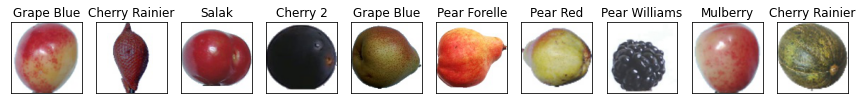

In [10]:
fig = plt.figure(figsize=(15,45));
for i in range(1,11):
    plt.subplot(1,10, i,)
    plt.title(data_train.classes[label])
    img, label = show_random_image()
    plt.imshow(img.permute(1, 2, 0));
    plt.xticks([]);
    plt.yticks([]);

In [11]:
train_size = int(0.8 * len(data_train)) 
val_size = len(data_train) - train_size
train_ds, val_ds = random_split(data_train, [train_size, val_size])
print("Train data length:{}\nValidation data length:{}".format(len(train_ds), len(val_ds)))

Train data length:54153
Validation data length:13539


In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=7, kernel_size=3, padding=1) # (batch_size,7,100,100)
        self.act1 = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2) # (batch_size,7,50,50)
        
        self.conv2 = nn.Conv2d(in_channels=7, out_channels=10, kernel_size=5, padding=2) # (batch_size,10,50,50)
        self.act2 = nn.ReLU()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2) # (batch_size,10,25,25)
        
#         self.conv3 = nn.Conv2d(in_channels=10, out_channels=12, kernel_size=5, padding=2) # (batch_size,12,25,25) hızlandırmak için network kısaltıldı.
#         self.act3 = nn.ReLU()
#         self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2) # (batch_size,12,12,12)
        
#         self.fc1 = nn.Linear(1728,  1048)
#         self.act4 = nn.ReLU()
        
        self.fc1 = nn.Linear(6250,  1048)
        self.act4 = nn.ReLU()
        
        self.fc2 = nn.Linear(1048,  524)
        self.act5 = nn.ReLU()
        
        self.fc3 = nn.Linear(524, 262)
        self.act6 = nn.Sigmoid()
        
        self.fc4 = nn.Linear(262, 131)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
#         x = self.conv3(x)
#         x = self.act3(x)
#         x = self.pool3(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act4(x)
        
        x = self.fc2(x)
        x = self.act5(x)
        
        x = self.fc3(x)
        x = self.act6(x)
        
        x = self.fc4(x)
        return x

In [13]:
model = NeuralNetwork()
print(model)
# summary = summary(model,(3, 100, 100)) # torch.Size([256, 3, 100, 100])

NeuralNetwork(
  (conv1): Conv2d(3, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(7, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act2): ReLU()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=6250, out_features=1048, bias=True)
  (act4): ReLU()
  (fc2): Linear(in_features=1048, out_features=524, bias=True)
  (act5): ReLU()
  (fc3): Linear(in_features=524, out_features=262, bias=True)
  (act6): Sigmoid()
  (fc4): Linear(in_features=262, out_features=131, bias=True)
)


In [14]:
model = NeuralNetwork()
model = model.to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),  lr = 10 **(-3))
epoch = 10  # 10
batch_size = 256

In [15]:
acc = []
def training(model, batch_size, epochs, loss, optimizer):
    for epoch in range(1, epochs + 1):
        model.train()
        dataloader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
        for (X_batch,y_batch) in tqdm(dataloader): 
            optimizer.zero_grad()
            
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            preds = model.forward(X_batch)
            
            loss_value = loss(preds, y_batch.long())
            loss_value.backward()            
            optimizer.step()
        
        dataloader_test = DataLoader(dataset=val_ds, batch_size=256)
        model.eval()
        with torch.no_grad():
            summa = 0
            for (X_batch,y_batch) in tqdm(dataloader_test):
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                preds = model.forward(X_batch)
                preds = torch.max(F.softmax(preds, dim=1), dim=1)
                correct= torch.eq(preds[1], y_batch)
                summa += torch.sum(correct).item() 
                
            acc.append(summa / len(val_ds))
            print(f'epoch: {epoch}, acc:{acc[-1]:.2%}')

In [16]:
%%time
training(model, batch_size, epoch, loss, optimizer)

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 1, acc:53.38%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 2, acc:72.16%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 3, acc:83.61%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 4, acc:85.04%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 5, acc:91.34%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 6, acc:95.01%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 7, acc:96.25%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 8, acc:97.84%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 9, acc:97.88%


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

epoch: 10, acc:98.92%
CPU times: user 55min 47s, sys: 18min 10s, total: 1h 13min 57s
Wall time: 51min 1s


In [17]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

# plot_accuracies(history)
# plot_losses(history)    

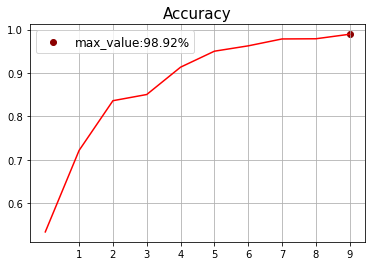

In [18]:
acc_max = max(acc)
y_acc_max = acc.index(max(acc))
plt.title('Accuracy', fontsize = 15 );
plt.xticks(np.arange(1, epoch));
plt.scatter( y_acc_max, acc_max, color='darkred', label = f'max_value:{acc_max:.2%}');
plt.plot(acc, color='red', );
plt.grid()
plt.legend(fontsize = 12);

In [19]:
dataloader_test = DataLoader(dataset=data_test, batch_size=256)
summa = 0
y_true = []
y_pred = []
for (X_batch,y_batch) in tqdm(dataloader_test):
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    preds = model.forward(X_batch)
    val_predict_class = preds.argmax(dim=-1)

    y_pred.extend([predict_class.item() for predict_class in val_predict_class])
    y_true.extend([val_label.item() for val_label in y_batch])

  0%|          | 0/89 [00:00<?, ?it/s]

In [20]:
print(f'acc:{accuracy_score(y_true, y_pred):.2%}')

acc:89.41%


In [21]:
cl_report = classification_report(y_true, y_pred,output_dict=True, target_names=data_train.classes)

In [22]:
report_df = pd.DataFrame(cl_report).T.sort_values(by=['precision', 'recall', 'f1-score'], ascending=False)
report_df.drop(['support'], axis=1, inplace=True)
report_df

,precision,recall,f1-score
Apple Granny Smith,1.000000,1.000000,1.000000
Cantaloupe 1,1.000000,1.000000,1.000000
Cherry 2,1.000000,1.000000,1.000000
Cherry Wax Black,1.000000,1.000000,1.000000
Cherry Wax Red,1.000000,1.000000,1.000000
...,...,...,...
Apple Red 1,0.623711,0.737805,0.675978
Raspberry,0.619403,1.000000,0.764977
Banana,0.593548,0.554217,0.573209
Beetroot,0.593220,0.933333,0.725389


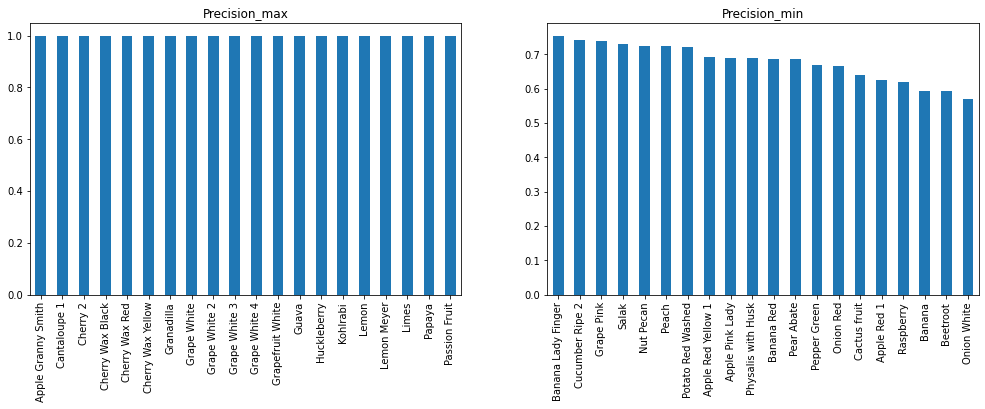

In [23]:
max_values = report_df.head(20)
min_values = report_df.tail(20)

plt.figure(figsize=(17, 5))


plt.subplot(1, 2, 1);
plt.title('Precision_max');
max_values['precision'].plot.bar();

plt.subplot(1, 2, 2);
plt.title('Precision_min');
min_values['precision'].plot.bar();